# Experiment number 1 (cifar100):

## Cutting between 25% of the samples according to the metrics and comparing to random cutting and a normal model without cutting
## the metrics: EL2N, forget, flip, pred sum, std and km

### get dataset and metrics and print correlation


In [1]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE
from utils import get_loader, get_cifar100

# globals
NUM_CLASSES = 100
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 100

NOTEBOOK_NAME = 'prune_25p'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar100', 'model', 'other.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar100()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist.npy'))
km100 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist_100.npy'))
km200 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist_200.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_true_forget = true_forget.sort()[1].numpy()
idx_sorted_km = np.argsort(km)
idx_sorted_km100 = np.argsort(km100)
idx_sorted_km200 = np.argsort(km200)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'forget': idx_sorted_forgetting, 'true_forget': idx_true_forget,
              'km': idx_sorted_km, 'km100': idx_sorted_km100, 'km200': idx_sorted_km200}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'Forget': change_counter.numpy(),
    'true_forget': true_forget.numpy(),
    'km': km,
    'km100': km100,
    'km200': km200
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,Forget,true_forget,km,km100,km200
EL2N,1.000000,0.763640,-0.931154,0.631182,0.015292,0.299591,0.364110,0.382782
Std,0.763640,1.000000,-0.653038,0.667967,0.121611,0.384026,0.440735,0.461708
True p sum,-0.931154,-0.653038,1.000000,-0.544786,0.114446,-0.250940,-0.299588,-0.316367
Forget,0.631182,0.667967,-0.544786,1.000000,0.394457,0.306184,0.355912,0.370274
true_forget,0.015292,0.121611,0.114446,0.394457,1.000000,0.006370,0.025260,0.031864
km,0.299591,0.384026,-0.250940,0.306184,0.006370,1.000000,0.805662,0.737580
km100,0.364110,0.440735,-0.299588,0.355912,0.025260,0.805662,1.000000,0.841076
km200,0.382782,0.461708,-0.316367,0.370274,0.031864,0.737580,0.841076,1.000000


In [2]:
# change to false in the first time you run this code
# after the first time the model will saved in models_data folder
already_trained = True

regular_model = ModelManager(NUM_CLASSES, 'no_prune', dir_=NOTEBOOK_NAME, load=already_trained)
if not already_trained:
    regular_model.train(loader_train, loader_test, loader_test, EPOCHS)

models = [regular_model]

num_train = int(NUM_TRAIN * (75. / 100.))

print()
for name, idx in idx_sorted.items():
    print(f'====     train model with 25% prune according to {name} most hard     ======')
    if already_trained:
        model_manager = ModelManager(NUM_CLASSES, f'{NOTEBOOK_NAME}_{name}', dir_=NOTEBOOK_NAME, load=True)
    else:
        loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, True)
        model_manager = ModelManager(NUM_CLASSES, f'{NOTEBOOK_NAME}_{name}', dir_=NOTEBOOK_NAME, load=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
    models.append(model_manager)
    print()


Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to el2n most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to std most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to pred_sum most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to forget most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to true_forget most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to km most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to km100 

In [3]:
[model.name for model in models]

['no_prune',
 'prune_25p_random',
 'prune_25p_el2n',
 'prune_25p_std',
 'prune_25p_pred_sum',
 'prune_25p_forget',
 'prune_25p_true_forget',
 'prune_25p_km',
 'prune_25p_km100',
 'prune_25p_km200']

### compare the results according to metrics


<Figure size 1200x900 with 0 Axes>

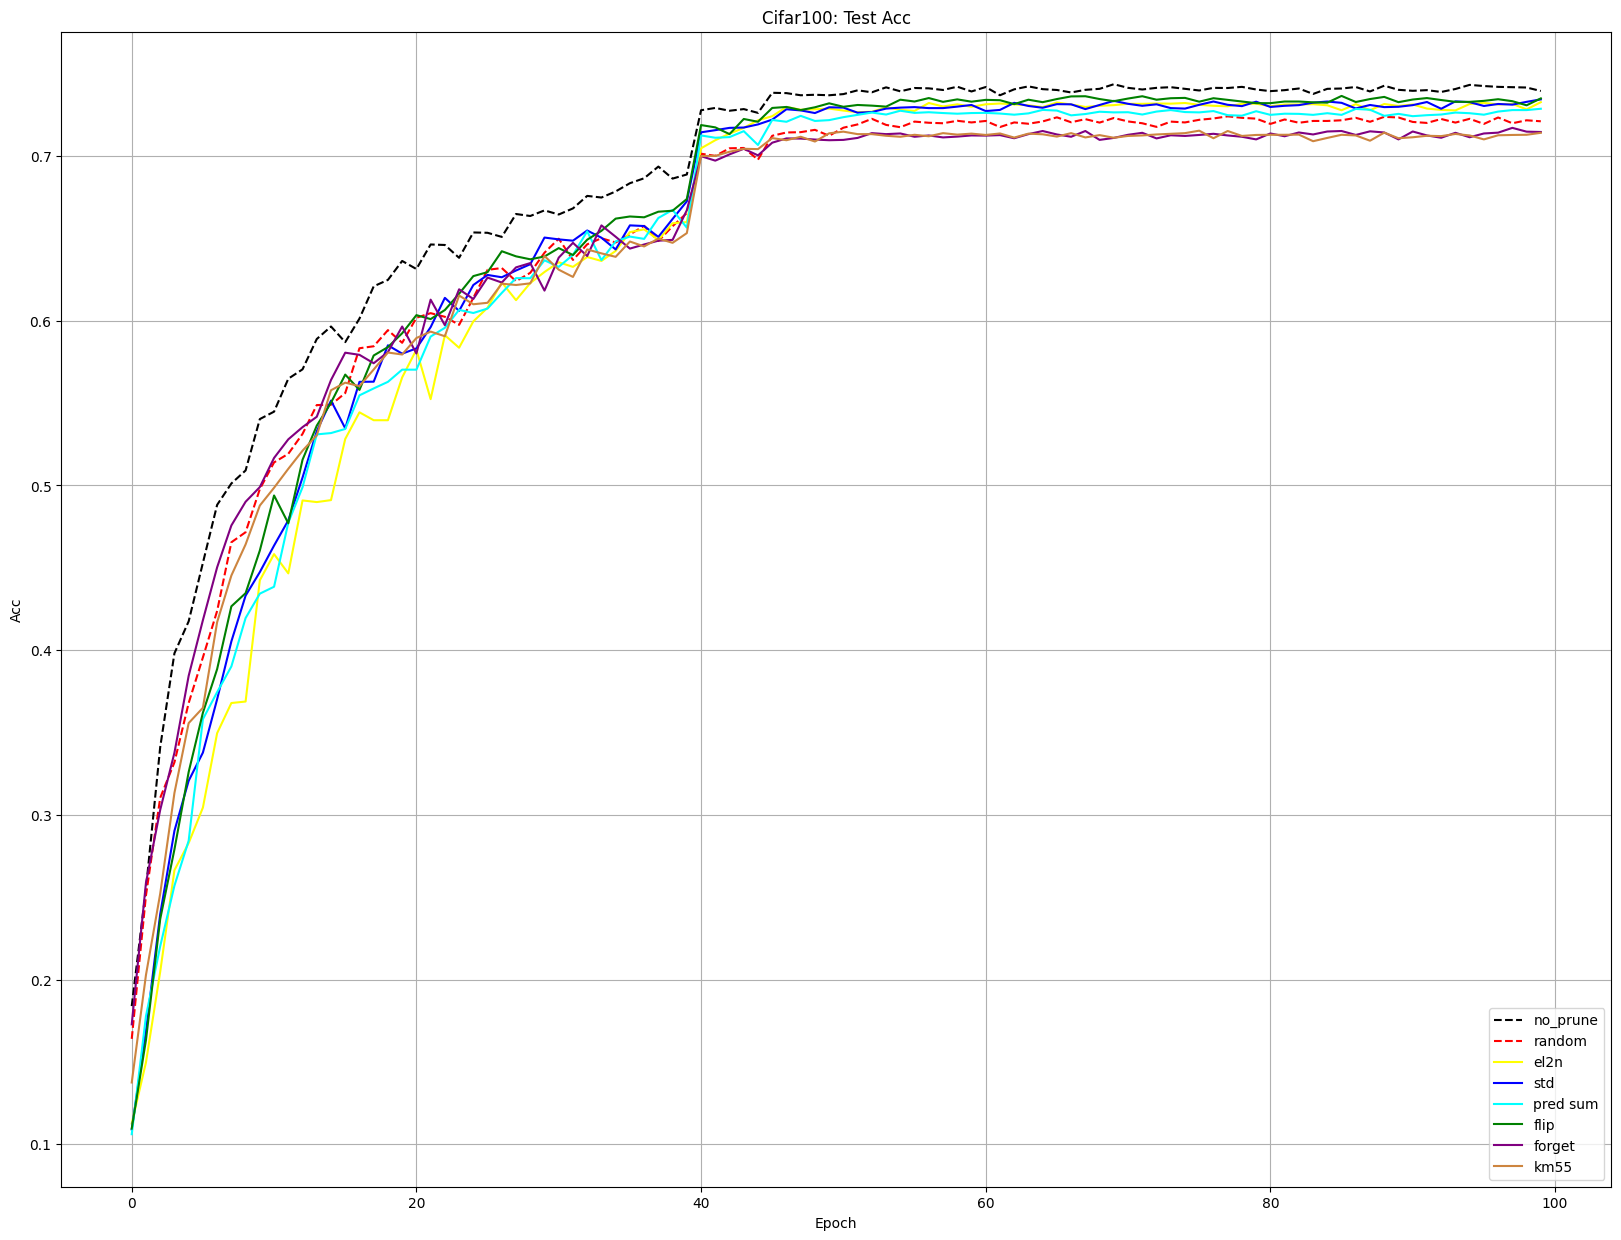

In [6]:
plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'darkorange','deepskyblue', 'indianred',   'hotpink')
#          no       rand    el2n     std     sum     flip      forget   km      km100        km200
markers = ('dashed', 'solid')

labels = {
    'no_prune': 'no_prune',
    'prune_25p_random': 'random',
    'prune_25p_el2n': 'el2n',
    'prune_25p_std': 'std',
    'prune_25p_pred_sum': 'pred sum',
    'prune_25p_forget': 'flip',
    'prune_25p_true_forget': 'forget',
    'prune_25p_km': 'km55',
    'prune_25p_km100': 'km100',
    'prune_25p_km200': 'km200',
}
plt.figure(figsize=(20, 15))
for i, model in enumerate(models):
    if labels[model.name] in [ 'km100', 'km200']:
        continue
    plt.plot(np.arange(EPOCHS), model.data['valid']['acc'], label=labels[model.name],
                c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar100: Test Acc')
plt.show()

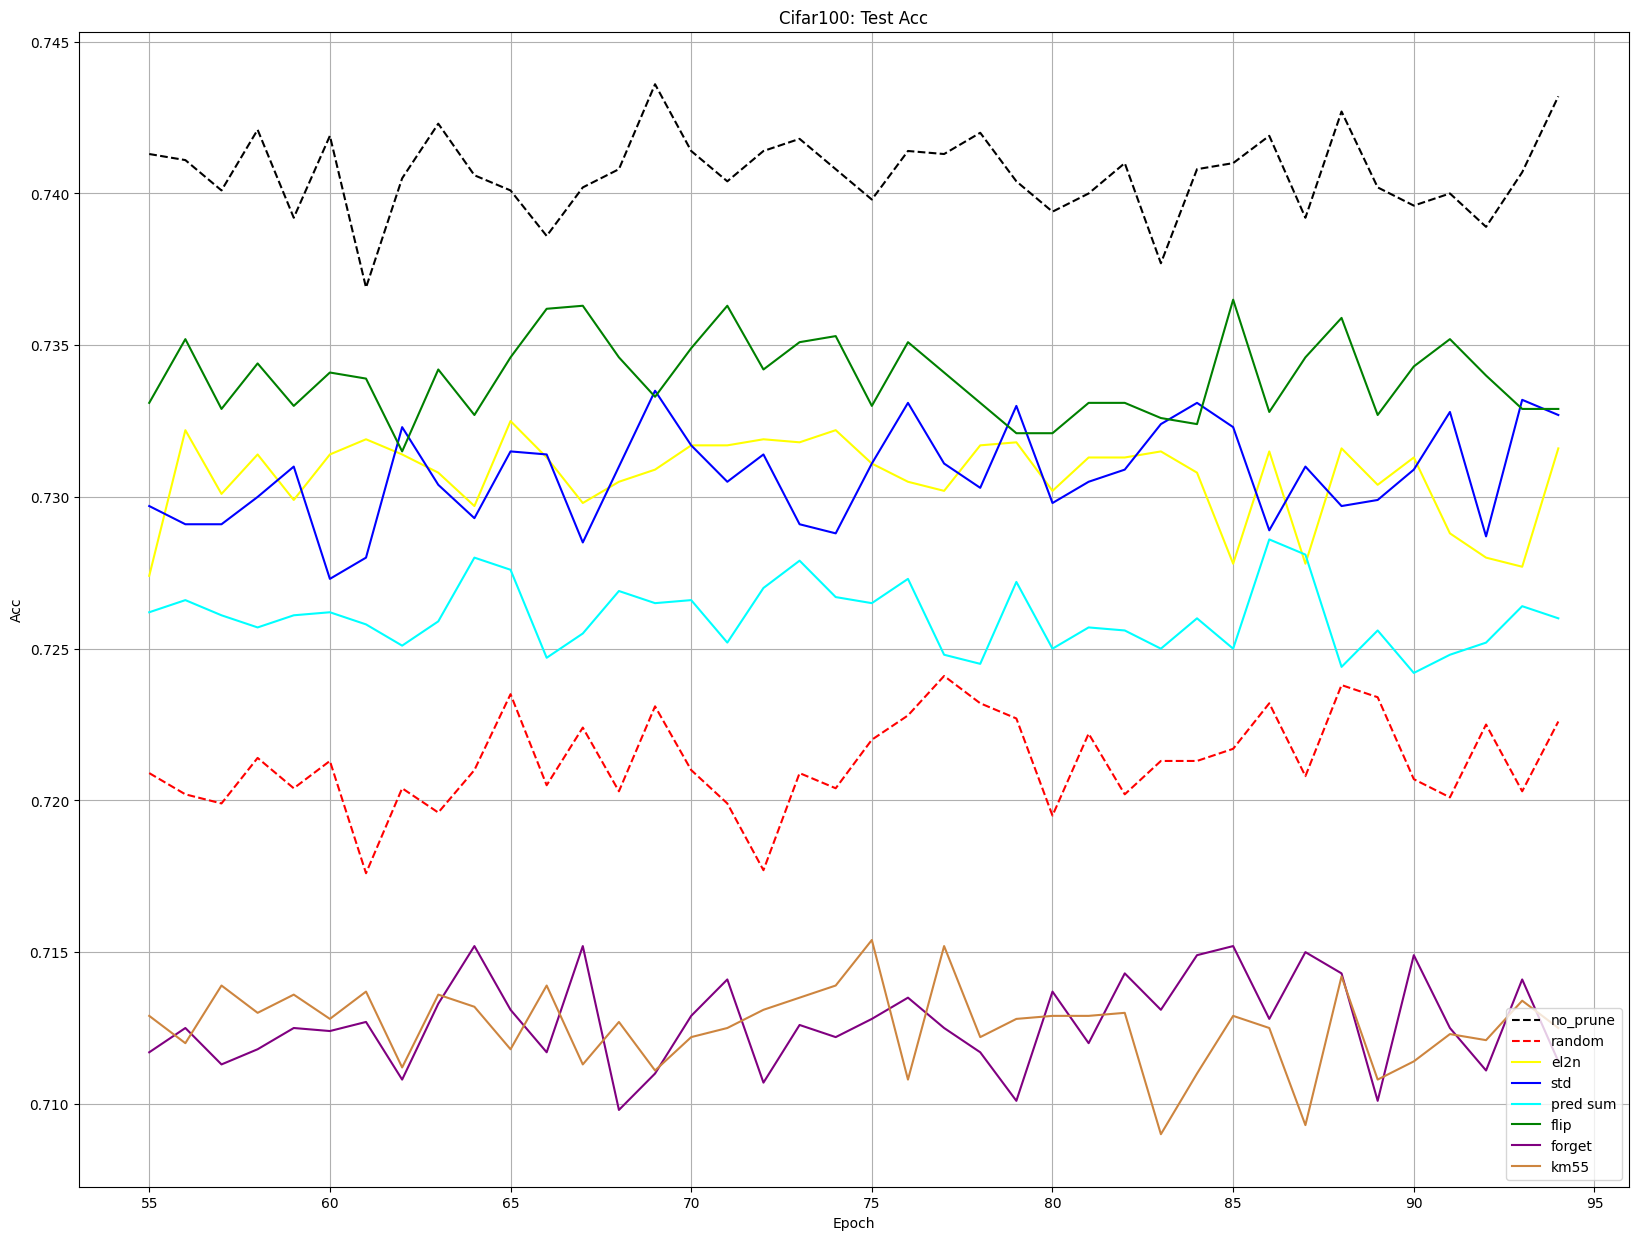

In [5]:
plt.figure(figsize=(20, 15))
for i, model in enumerate(models):
    if labels[model.name] in [ 'km100', 'km200']:
        continue
    plt.plot(np.arange(55, 95), model.data['valid']['acc'][55:95], label=labels[model.name],
                c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar100: Test Acc')
plt.show()

### compare the results according to different k for km metric


<Figure size 1200x900 with 0 Axes>

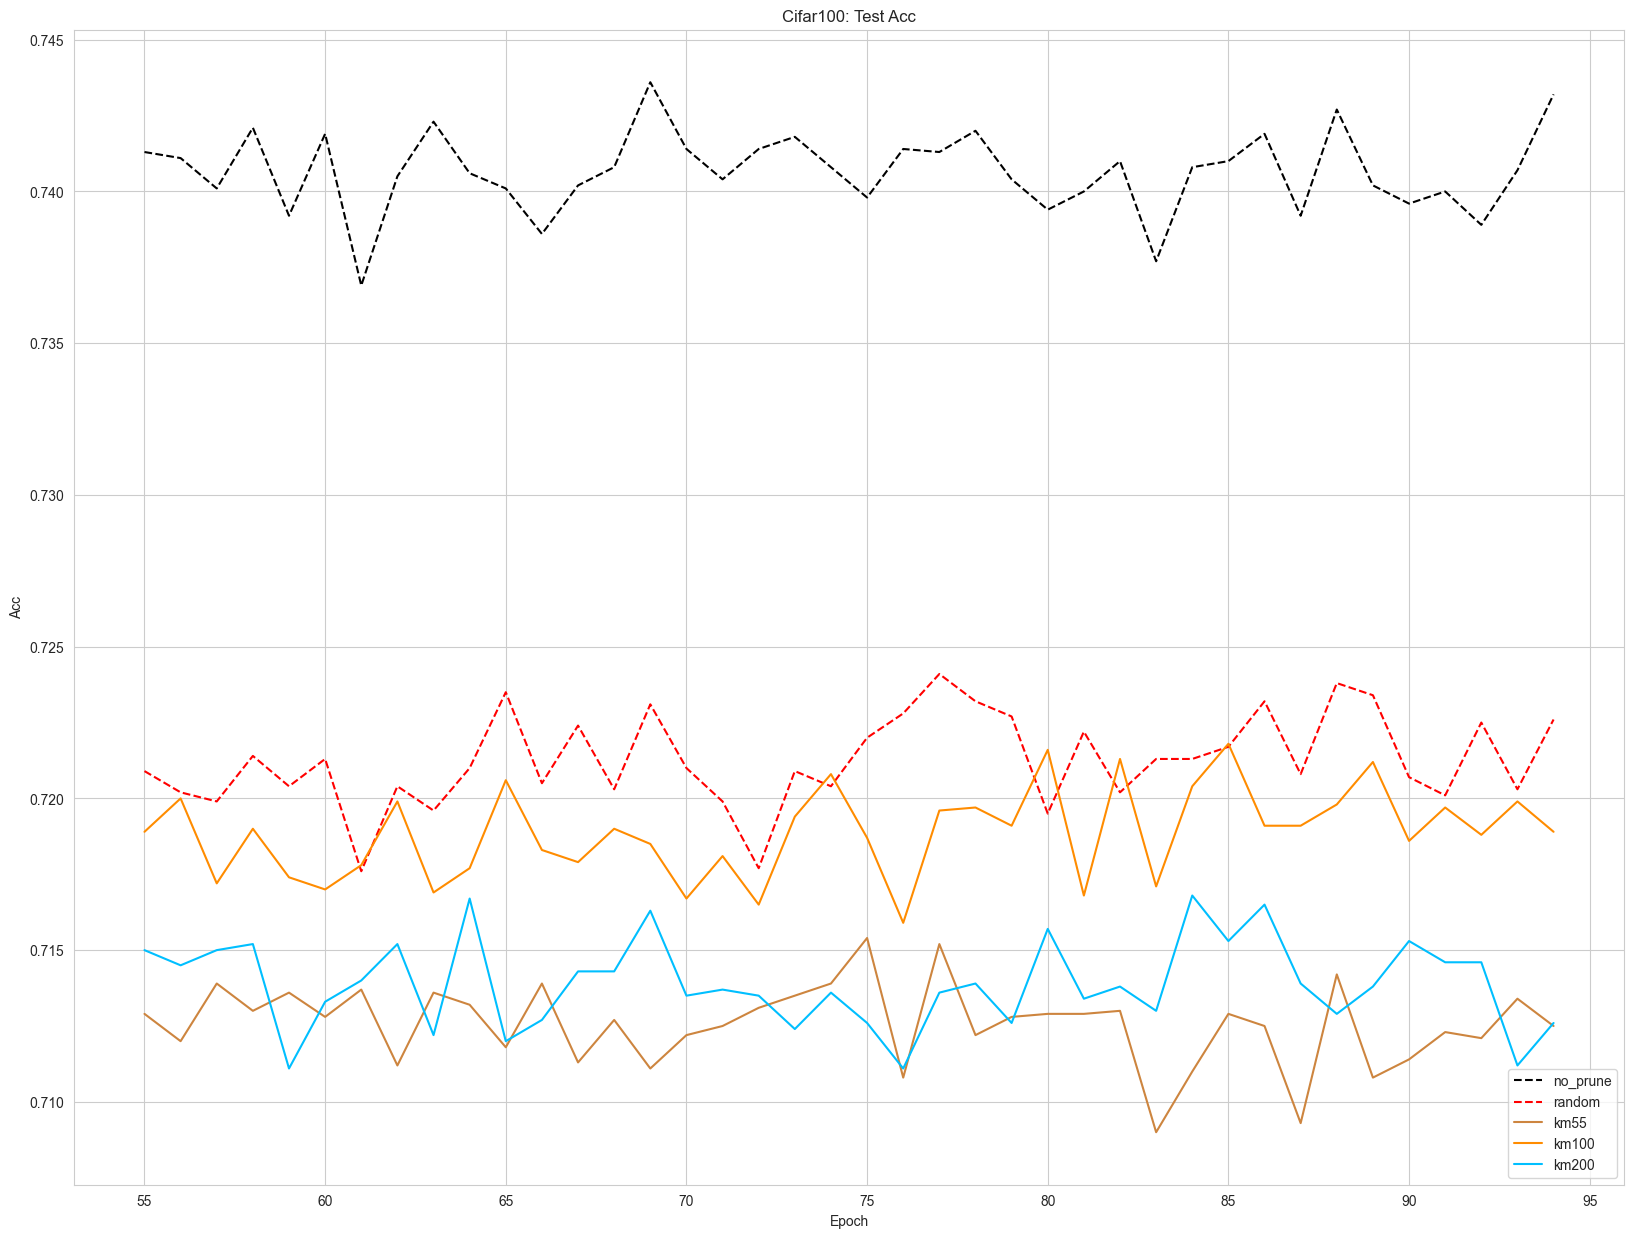

In [5]:
plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'darkorange','deepskyblue', 'indianred',   'hotpink')
#          no       rand    el2n     std     sum     flip      forget   km      km100        km200
markers = ('dashed', 'solid')

labels = {
    'no_prune': 'no_prune',
    'prune_25p_random': 'random',
    'prune_25p_el2n': 'el2n',
    'prune_25p_std': 'std',
    'prune_25p_pred_sum': 'pred sum',
    'prune_25p_forget': 'flip',
    'prune_25p_true_forget': 'forget',
    'prune_25p_km': 'km55',
    'prune_25p_km100': 'km100',
    'prune_25p_km200': 'km200',
}
plt.figure(figsize=(20, 15))
for i, model in enumerate(models):
    if labels[model.name] in ['km55', 'km100', 'km200', 'no_prune', 'random']:
        plt.plot(np.arange(55, 95), model.data['valid']['acc'][55:95], label=labels[model.name],
                 c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar100: Test Acc')
plt.show()

<Figure size 1200x900 with 0 Axes>

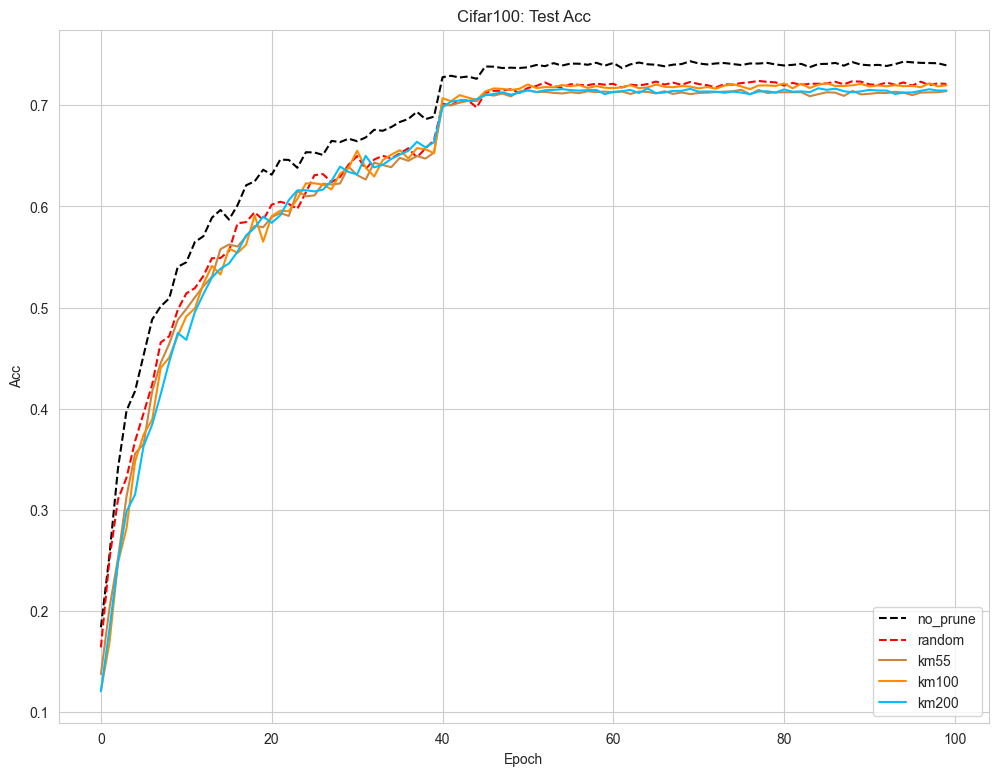

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'darkorange','deepskyblue', 'indianred',   'hotpink')
#          no       rand    el2n     std     sum     flip      forget   km      km100        km200
markers = ('dashed', 'solid')

save = {}
epochs_idx = np.arange(EPOCHS)
plt.figure(figsize=(12, 9))
for i, model in enumerate(models):
    if labels[model.name] in ['km55', 'km100', 'km200', 'no_prune', 'random']:
        model_valid_acc = np.array(model.data['valid']['acc'])
        plt.plot(epochs_idx, model_valid_acc, label=labels[model.name],
                 c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
    # print(model.name, np.mean(model_valid_acc))
    # save[labels[model.name]] = model_valid_acc

plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar100: Test Acc')
plt.show()



In [6]:
save.keys()

dict_keys(['no_prune', 'random', 'el2n', 'std', 'pred sum', 'flip', 'forget', 'km 55'])

In [7]:
import pickle

with open(os.path.join(DIR_ROOT_SAVE, 'cifar100_25_graph'), 'wb') as f:
    pickle.dump(save, f)